# Identificación por mínimos cuadrados recursivos extendidos

Se tiene el siguiente sistema a identificar

$$ y_k +a y_{k-1} = b u_{k-1} + e_{k} + c  e_{k-1}$$

Que puede factorizarse de la siguiente manera 

$$ y_k = -a y_{k-1} + b u_{k-1} + e_{k} + c  e_{k-1} $$

Quisieramos que tuviera la forma
$$ y_k = \varphi_{k}^\top \theta  + e_{k} $$
con
$$ \varphi_k = [-y_{k-1}, u_{k-1}]$$
$$ \theta = [a , b ]$$

¿Pero qué hacemos con el modelo de la perturbación?

In [1]:
import control as ctrl
import numpy as np
from matplotlib import pyplot as plt
import scipy as sc

In [3]:
# Parámetros verdaderos
a, b, c = -0.8, 0.5, 0.0
def obtener_datos(u,e,A=a,B=b,C=0):
    N = len(u)
    y = np.zeros_like(u)
    for k in range(1, N):  
        y[k] = -A*y[k-1] + B*u[k-1] + e[k] + C*e[k-1] # c=0

    return y

In [6]:
# Estimador por mínimos cuadrados recursivo para un modelo ARX
def estimador_RLS(u,y,na=1, nb=1,lambda_=1,theta_ini=None, theta_real=None,plot=True):
    N = len(u)
    if np.all(theta_ini)==None:
        theta_hat = np.zeros(na+nb)       # estimación inicial [a_hat, b_hat]
    else:
        theta_hat = theta_ini
    P = 100 * np.eye(na+nb)          # matriz de incertidumbre grande
    err = np.zeros_like(y)
    y_hat = np.zeros_like(y)

    theta_hist = []    
    k_range = range(na+1, N)
    for k in k_range:
        phi = np.concatenate((-y[k-1:k-na-1:-1], u[k-1:k-nb-1:-1]))   # vector de regresores
        y_hat[k] = phi @ theta_hat
        err[k] = y[k] - y_hat[k]

        K = P @ phi / (lambda_ + phi.T @ P @ phi)
        theta_hat = theta_hat + K * err[k]
        P = (P - np.outer(K, phi) @ P) / lambda_

        theta_hist.append(theta_hat.copy())

    theta_hist = np.array(theta_hist)

    # Validación
    N_lag = 50
    ree = np.correlate(err,err,'full')    
    rey = np.correlate(err,y_hat,'full')
    ryy = np.correlate(y_hat,y_hat,'full')
    RN = ree/(rey*ryy+0.001)**0.5    
    lags = np.arange(-len(err)+1, len(err))
    center = len(ree) // 2
    ree = ree[center-N_lag:center+N_lag+1]
    RN = RN[center-N_lag:center+N_lag+1]
    lags_plot = lags[center-N_lag:center+N_lag+1]
    ree_max_val = 2.17/np.sqrt(N)*ree[N_lag]
    RN_max_val = 2.17/np.sqrt(N)*RN[N_lag]
    print(f"ree(0)={ree[N_lag]}  ree(1)={ree[N_lag+1]}   Maximo permitido: {ree_max_val}")

    if plot:
        plt.subplot(211)        
        plt.step(k_range,err[k_range],where='post')
        #plt.xlabel('Tiempo [s]')
        plt.ylabel('Error de predicción')
        plt.subplot(212)
        for idx_na in range(0,na):
            plt.step(k_range,theta_hist[:,idx_na], label=f"$\\hat{{a_{idx_na+1}}}$",where='post')
        for idx_nb in range(0,nb):
            plt.step(k_range,theta_hist[:,na+idx_nb], label=f"$\\hat{{b_{idx_nb+1}}}$",where='post')
        if theta_real!=None:
            colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
            for idx_na in range(na):
                color = colors[idx_na % len(colors)]
                plt.axhline(theta_real[idx_na], linestyle='--', color=color, label=f"$a_{idx_na}$")
            for idx_nb in range(nb):
                color = colors[(idx_nb+na) % len(colors)]
                plt.axhline(theta_real[idx_nb+na], linestyle='--', color=color, label=f"$b_{idx_nb}$")            
        plt.legend()
        plt.xlabel('k')
        plt.ylabel('$\\theta$')
        plt.show()

        # Observemos la correlación del error de predicción

        #Pee = np.fft.fft(ree)
        #w = np.fft.fftfreq(N, 1)*2*np.pi 
        plt.figure()
        #plt.subplot(211)
        plt.plot(lags_plot,ree)
        plt.ylabel('$r_{{ee}}$')    
        plt.axhline(ree_max_val, linestyle='--', color='r', label=f"$ree_{{max}}$") 
        plt.title('Validación del modelo')           
        #plt.subplot(212)
        #plt.plot(lags_plot,RN)
        #plt.ylabel('$R_{{e\\hat{{y}}}}$')
        #plt.axhline(RN_max_val, linestyle='--', color='r', label=f"$R_{{N,max}}$") 
        plt.xlabel('lag')
        plt.show()

    return theta_hist,P,err,ree


## Influencia de la estructura del modelo

entrada PRBS + ruido coloreado

Observar que al usar RLS pensando que el modelo es ARX y el ruido es blanco, se comete un error en la estimación.
Si miramos solamente el desvío del estimador, pensamos que alcanzó una buena estimación. Claramente esto no es correcto porque difiere mucho del valor verdadero.

Un indicio de este problema lo muestra la gráfica de correlación del error de estimación. Se ve cierto grado de correlación lo que implica que los datos todavía tienen más información para extraer

/tmp/ipykernel_1475676/1512210763.py:32: RuntimeWarning: invalid value encountered in sqrt
  RN = ree/(rey*ryy+0.001)**0.5


ree(0)=735.9243499892649  ree(1)=-200.91574812273922   Maximo permitido: 31.939116789534097


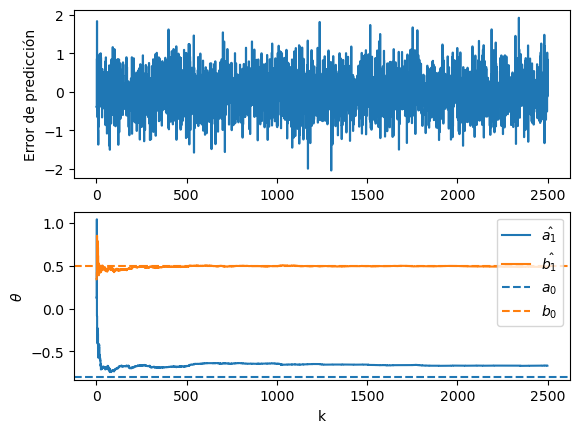

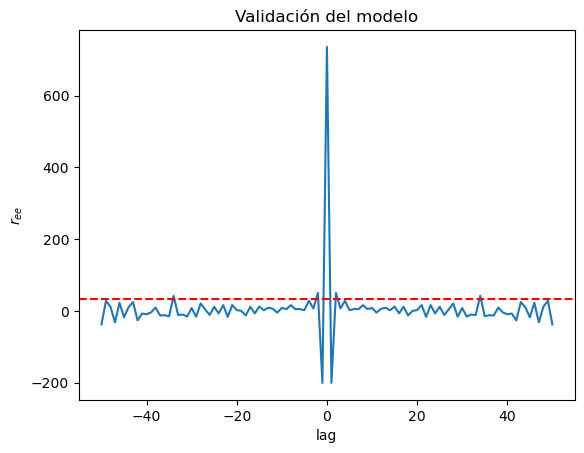

Theta estimado = [-0.66429874  0.48816424]
Desvío de la estimación = [0.01030004 0.01000402]


In [9]:
N = 2500
t = np.arange(N)
u = np.sign(np.random.randn(N))

sigma_e = 0.5
e = sigma_e*np.random.randn(N)
y = obtener_datos(u,e,C=-0.5)

theta_hat,P,_,_ = estimador_RLS(u,y,lambda_=1,na=1,nb=1, theta_real=[a,b])
print(f"Theta estimado = {theta_hat[-1,:]}")
print(f"Desvío de la estimación = {sigma_e*np.sqrt(P.diagonal().flatten())}")

### Modelos estocásticos

Para solucionar el problema visto en el ensayo anterior se puede incorporar el modelo del ruido a la identificación.

Consideremos el modelo a identificar:
$$A(q) y_k = B(q) u_k + C(q) e_k$$

con $\{e_k\}$ ruido blanco.

No podemos transformar este modelo a uno de regresión, porque no conocemos $e_k$, entonces no tendríamos forma de incorporarlo al regresor $\varphi_k$.

Si embargo nos podemos valer del error de predicción $\epsilon_k = y_k - \varphi_{k-1} \hat{\theta}_{k-1}$ para aproximar $e_k$

Resulta:
$$\varphi_k =[-y_{k-1}, \dots,-y_{k-n_a}, u_{k-1},\dots,u_{k-n_b},\epsilon_{k-1},\dots,\epsilon_{k-n_c} ] $$
$$\theta = [a_1, \dots, a_{n_a}, b_1, \dots, b_{n_b},c_1,\dots, c_{n_c}]$$

In [10]:
# Estimador por mínimos cuadrados extendido para un modelo ARX con ruido coloreado
def estimador_ELS(u,y,na=1, nb=1, nc=1, lambda_=1,theta_real=None,plot=True):
    N = len(u)
    theta_hat = np.zeros(na+nb+nc)       # estimación inicial [a_hat, b_hat]
    P = 100 * np.eye(na+nb+nc)          # matriz de covarianza grande
    err = np.zeros_like(y)

    theta_hist = []    
    k_range = range(na+1, N)
    for k in k_range:
        phi = np.concatenate((-y[k-1:k-na-1:-1], u[k-1:k-nb-1:-1], err[k-1:k-nc-1:-1]))   # vector de regresores
        y_hat = phi @ theta_hat
        err[k] = y[k] - y_hat

        K = P @ phi / (lambda_ + phi.T @ P @ phi)
        theta_hat = theta_hat + K * err[k]
        P = (P - np.outer(K, phi) @ P) / lambda_

        theta_hist.append(theta_hat.copy())

    theta_hist = np.array(theta_hist)

    if plot:
        plt.subplot(211)        
        plt.step(k_range,err[k_range],where='post')
        #plt.xlabel('Tiempo [s]')
        plt.ylabel('Error de predicción')
        plt.subplot(212)
        for idx_na in range(0,na):
            plt.step(k_range,theta_hist[:,idx_na], label=f"$\\hat{{a_{idx_na+1}}}$",where='post')
        for idx_nb in range(0,nb):
            plt.step(k_range,theta_hist[:,na+idx_nb], label=f"$\\hat{{b_{idx_nb+1}}}$",where='post')
        for idx_nc in range(0,nc):
            plt.step(k_range,theta_hist[:,na+nb+idx_nc], label=f"$\\hat{{c_{idx_nc+1}}}$",where='post')
        if theta_real!=None:
            colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
            for idx_na in range(na):
                color = colors[idx_na % len(colors)]
                plt.axhline(theta_real[idx_na], linestyle='--', color=color, label=f"$a_{idx_na}$")
            for idx_nb in range(nb):
                color = colors[(idx_nb+na) % len(colors)]
                plt.axhline(theta_real[idx_nb+na], linestyle='--', color=color, label=f"$b_{idx_nb}$")            
            for idx_nc in range(nc):
                color = colors[(idx_nc+na+nb) % len(colors)]
                plt.axhline(theta_real[idx_nc+na+nb], linestyle='--', color=color, label=f"$c_{idx_nc}$")            
        plt.legend()
        plt.xlabel('k')
        plt.ylabel('$\\theta$')
        plt.show()

        # Observemos la correlación del error de predicción
        N_lag = 50
        ree = np.correlate(err,err,'full')
        lags = np.arange(-len(err)+1, len(err))
        center = len(ree) // 2
        ree = ree[center-N_lag:center+N_lag+1]
        lags_plot = lags[center-N_lag:center+N_lag+1]

        #Pee = np.fft.fft(ree)
        #w = np.fft.fftfreq(N, 1)*2*np.pi 
        plt.figure()
        #plt.subplot(211)
        plt.plot(lags_plot,ree)
        plt.ylabel('$r_{{ee}}$')
        plt.xlabel('lag')
        #plt.subplot(212)
        #plt.plot(w,Pee)
        #plt.ylabel('$S_{{ee}}$')
        #plt.xlabel('$\\omega_r [rad]$')
    return theta_hist,P


### Repetimos ensayo anterior pero usando ELS

En este caso vemos que el residuo no queda autocorrelacionado

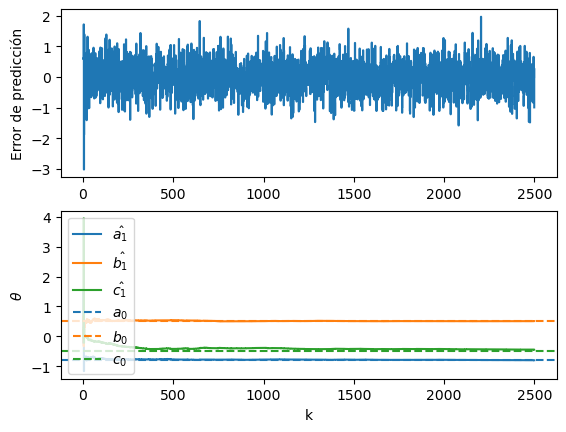

Theta estimado = [-0.79423788  0.51078079 -0.44137847]
Desvío de la estimación = [0.01147337 0.01001026 0.02252378]


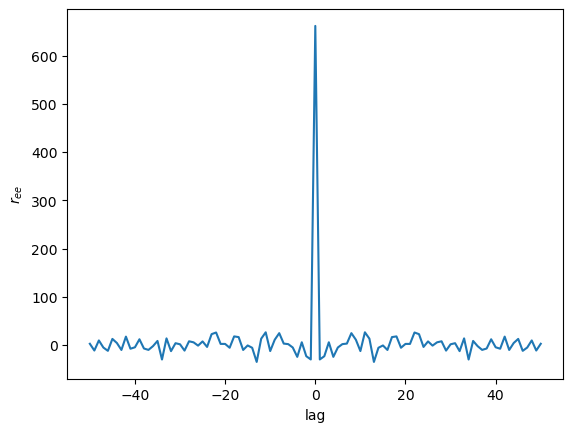

In [11]:
N = 2500
t = np.arange(N)
u = np.sign(np.random.randn(N))

sigma_e = 0.5
e = sigma_e*np.random.randn(N)
c = -0.5
y = obtener_datos(u,e,C=c)

theta_hat,P = estimador_ELS(u,y,lambda_=1,na=1,nb=1,nc=1, theta_real=[a,b,c])
print(f"Theta estimado = {theta_hat[-1,:]}")
print(f"Desvío de la estimación = {sigma_e*np.sqrt(P.diagonal().flatten())}")

### Repetimos ensayo anterior pero usando sippy


Modelo identificado (discreto):
<TransferFunction>: sys[16]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 1.0

    0.5044
  ----------
  z - 0.8051
Polinomios Estimados:
A(z): [1.0, -0.8051407377067369]    Real  [1, -0.8]
B(z): [0.5044256159065621]   Real  [0.5]
C(z): [1.0, -0.5011753670089086]   Real  [1 -0.5]


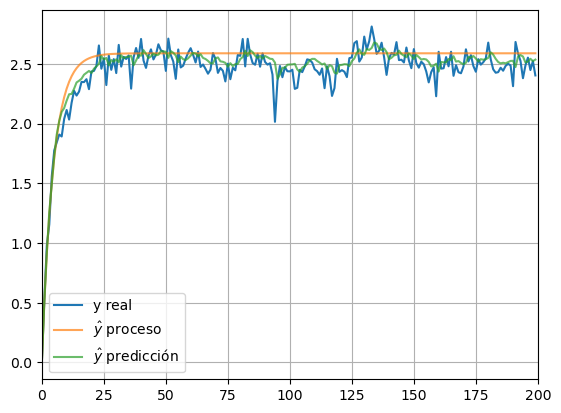

In [13]:
import sippy_unipi as sippy 
from sippy_unipi import functionset as fset
from sippy_unipi import functionsetSIM as fsetSIM

# ====================================
# 1. Parámetros y datos simulados
# ====================================
N = 2500
t = np.arange(N)
u = np.sign(np.random.randn(N))  # entrada ±1

sigma_e = 0.5
e = sigma_e*np.random.randn(N)

# Parámetros reales (ejemplo ARMAX)
c = -0.5  # coef. ruido coloreado
y = obtener_datos(u,e,C=c)

# ====================================
# 2. Identificación con sippy
# ====================================
# Ordenes: AR=1, X=1 (entrada), MA=1
sys_id = sippy.system_identification(y, u,
                                     'ARMAX', # probar con 'ARX', 'ARMA' ... Pero hay que ajustar los oredenes
                                     na_ord=1, nb_ord=1, nc_ord=1,
                                     delays=1)

# Modelo identificado
Gz = sys_id.G
print("Modelo identificado (discreto):")
print(Gz)

# Parámetros AR, X, MA
print("Polinomios Estimados:")
print(f"A(z): {sys_id.DENOMINATOR[0][0]}    Real  [1, {a}]")
print(f"B(z): {sys_id.NUMERATOR[0][0]}   Real  [{b}]")
print(f"C(z): {sys_id.NUMERATOR_H[0][0]}   Real  [1 {c}]")

# ====================================
# 3. Validación
# ====================================
N = 200
t = np.arange(N)
u = np.ones(N)

sigma_e = 0.1
e = sigma_e*np.random.randn(N)

# Parámetros reales (ejemplo ARMAX)
y = obtener_datos(u,e,C=c)
y_hat_prediction = fset.validation(sys_id,u,y,t, k = 1)

# La simulación se realiza sobre el sistema en espacio de estados
Gss = ctrl.tf2ss(sys_id.G)
sys_response = fset.forced_response(Gss,T=t,U=u)
# Otra forma de simular la respuesta del sistema
#x,y_hat_process = fsetSIM.SS_lsim_process_form(Gss.A, Gss.B, Gss.C, Gss.D, u.reshape((1,N)), np.array([[0]]))

plt.plot(y, label="y real")
#plt.plot(y_hat_process.reshape(-1), label="$\hat{{y}}$ proceso", alpha=0.7)
plt.plot(sys_response.y.reshape(-1), label="$\hat{{y}}$ proceso", alpha=0.7)
plt.plot(y_hat_prediction.reshape(-1),label="$\hat{{y}}$ predicción",alpha=0.7)
plt.legend()
plt.grid()
plt.xlim(0,200)
plt.show()

